# Locate peak on 2-D area detector image

From *2021-03 APS Python Training for Bluesky Data Acquisition*.

**Objective**

Measure a simulated diffraction spot with an EPICS area detector
and find its centroid and width.

Note: The position, width, and peak intensity of the simulated is randomized and will be different each time this note book is run.  In fact, the EPICS support applies a small amount of jitter to the position to better simulate a real signal.

## Start the `instrument` package

Our instrument package is in the `bluesky` subdirectory here so we add that to the search path before importing it.

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(".", "bluesky")))
from instrument.collection import *

I Wed-00:32:49 - #### Bluesky Framework ####
I Wed-00:32:49 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/framework/check_python.py
I Wed-00:32:49 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/framework/check_bluesky.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Wed-00:32:49 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/framework/initialize.py
I Wed-00:32:50 - using databroker catalog 'class_2021_03'
I Wed-00:32:50 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/framework/metadata.py
I Wed-00:32:50 - #### Devices ####
I Wed-00:32:50 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/devices/area_detector.py
I Wed-00:32:50 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/devices/calculation_records.py
I Wed-00:32:52 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/devices/ioc_stats.py
I Wed-00:32:52 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/devices/motors.py
I Wed-00:32:52 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/devices/noisy_det

Count the detector : record an image.

In [2]:
RE(bp.count([adsimdet], md={"motive": "locate_image_peak"}))



Transient Scan ID: 33     Time: 2021-03-17 00:32:55
Persistent Unique Scan ID: '766d818f-bf8d-4ea1-952f-6517d5122065'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 00:32:55.6 |
+-----------+------------+
generator count ['766d818f'] (scan num: 33)


('766d818f-bf8d-4ea1-952f-6517d5122065',)

## View the image

Since area detector images are typically quite large, they are never 
read into Python memory during data acquisition.  To view the image 
here, we need to use the *databroker* which reads the run data.  The 
run data includes the reference to the file that contains the image.

### Get the run
First, get the most recent run from `db`.

In [3]:
run = db.v2[-1]

Look at the run's metadata.  Confirm it has the `{"motive": "locate_image_peak"}` metadata we added.  That was stored in the `start` document.

In [4]:
print(run.metadata["start"]["motive"])

locate_image_peak


### Primary stream
The image was collected in the primary data stream.  Get the primary stream data from the database.

In [5]:
primary_data = run.primary.read()
primary_data

<xarray.Dataset>
Dimensions:         (dim_0: 1, dim_1: 1024, dim_2: 1024, time: 1)
Coordinates:
  * time            (time) float64 1.616e+09
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    adsimdet_image  (time, dim_0, dim_1, dim_2) uint8 14 11 9 17 ... 16 7 17 15

### Get the image data

Get the named image `adsimdet_image` from the primary stream.

In [6]:
image = primary_data["adsimdet_image"]
image

<xarray.DataArray 'adsimdet_image' (time: 1, dim_0: 1, dim_1: 1024, dim_2: 1024)>
array([[[[14, 11,  9, ..., 17, 13,  7],
         [15, 15, 11, ..., 12, 17,  8],
         [ 9, 17,  7, ..., 15,  6,  7],
         ...,
         [ 6, 10, 16, ..., 15,  8,  8],
         [14,  9, 12, ..., 10,  7,  7],
         [13,  9,  7, ...,  7, 17, 15]]]], dtype=uint8)
Coordinates:
  * time     (time) float64 1.616e+09
Dimensions without coordinates: dim_0, dim_1, dim_2
Attributes:
    object:   adsimdet

### Image frame
This image object has rank of 4.  We just want the image frame (the last two indices).  Select the first item of each of the first two indices (time, frame number).

In [7]:
frame = image[0][0]
frame

<xarray.DataArray 'adsimdet_image' (dim_1: 1024, dim_2: 1024)>
array([[14, 11,  9, ..., 17, 13,  7],
       [15, 15, 11, ..., 12, 17,  8],
       [ 9, 17,  7, ..., 15,  6,  7],
       ...,
       [ 6, 10, 16, ..., 15,  8,  8],
       [14,  9, 12, ..., 10,  7,  7],
       [13,  9,  7, ...,  7, 17, 15]], dtype=uint8)
Coordinates:
    time     float64 1.616e+09
Dimensions without coordinates: dim_1, dim_2
Attributes:
    object:   adsimdet

### Show the image

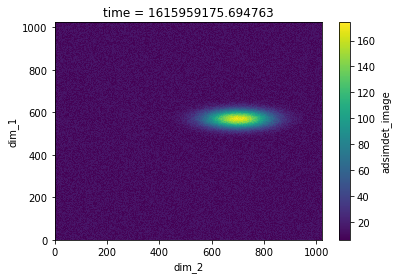

In [8]:
frame.plot.pcolormesh()
# In MS VSCode, this one cell stalls, use JupyterLab from here.  :(

### Center & size of spot
Determine the center and width of this spot in both directions.  We'll use our own function (from `instrument/utils/image_analysis.py`) since no package gives us all of this in one place.  Our function is extracted and modified from the *PeakStats* support in bluesky's *BestEffortCallback* and also uses a function from *scipy*.

Note that the `centroid` measure here is the channel number weighted by the intensity value (as computed by the *scipy* package).  The `fwhm` measure here (from the *BestEffortCallback*) is the computed difference in channel number between the high and low side of the maximum at half the maximum-minimum value.  The `crossings` measure shows the interpolated locations at which the intensity crossed this half value.  The other measures should be self-explanatory.

In [9]:
analyze_image(frame)

================= =========================== ===========================
measure           vertical (dim_1)            horizontal (dim_2)         
================= =========================== ===========================
centroid_position 572.0202418591646           701.1088745063624          
fwhm              70.3892491504281            207.84039052215894         
crossings         [536.82561728 607.21486643] [597.18867925 805.02906977]
maximum           (572, 45991)                (712, 23530)               
center_position   521.985298449022            544.5944465809232          
minimum           (767, 11297)                (75, 11348)                
================= =========================== ===========================

